In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset02/labeled_data.csv


In [2]:
import numpy as np
import pandas as pd
import os, re

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, classification_report
import time
import datetime

In [3]:
# Fine-Tuning Parameters
learning_rate = 2e-5
batch_size = 32
epochs = 20  # Adjust the number of epochs as needed

# Load the data
df = pd.read_csv('/kaggle/input/dataset02/labeled_data.csv')

# Function to clean tweets
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", x).split())

# Apply tweet cleaning
df['tweet'] = df['tweet'].apply(strip_all_entities)

# Train-test-validation split
train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

# Get the lists of sentences and their labels
trn_sentences = train['tweet'].values
train_labels = train['class'].values

tst_sentences = test['tweet'].values
test_labels = test['class'].values

val_sentences = validation['tweet'].values
validation_labels = validation['class'].values

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [4]:
# Function to encode sentences and apply padding and masking
def bert_encode(data, max_len):
    input_ids = []
    attention_masks = []

    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                         add_special_tokens=True,
                                         max_length=max_len,
                                         padding='max_length',
                                         truncation=True,
                                         return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids), np.array(attention_masks)

# Encode sentences for BERT input
MAX_LEN = 128  # Experiment with different sequence lengths
train_inputs, train_masks = bert_encode(trn_sentences, MAX_LEN)
validation_inputs, validation_masks = bert_encode(val_sentences, MAX_LEN)

# Convert data to PyTorch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create DataLoader for training and validation sets
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=3,
    output_attentions=False,
    output_hidden_states=False,
)
model.cuda()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [9]:
# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [12]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Regularization
model.dropout = nn.Dropout(0.1)  # Experiment with dropout rate

# Training Loop
loss_values = []
for epoch_i in range(epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    # Evaluation on validation set after each epoch
    print("")
    print("Running Validation...")
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("  Accuracy: {0:.2f}".format(eval_accuracy / nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))



======== Epoch 1 / 20 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:25.
  Batch    80  of    620.    Elapsed: 0:00:50.
  Batch   120  of    620.    Elapsed: 0:01:15.
  Batch   160  of    620.    Elapsed: 0:01:39.
  Batch   200  of    620.    Elapsed: 0:02:04.
  Batch   240  of    620.    Elapsed: 0:02:29.
  Batch   280  of    620.    Elapsed: 0:02:54.
  Batch   320  of    620.    Elapsed: 0:03:19.
  Batch   360  of    620.    Elapsed: 0:03:43.
  Batch   400  of    620.    Elapsed: 0:04:08.
  Batch   440  of    620.    Elapsed: 0:04:33.
  Batch   480  of    620.    Elapsed: 0:04:58.
  Batch   520  of    620.    Elapsed: 0:05:23.
  Batch   560  of    620.    Elapsed: 0:05:47.
  Batch   600  of    620.    Elapsed: 0:06:12.

  Average training loss: 0.17
  Training epoch took: 0:06:24

Running Validation...
  Accuracy: 0.92
  Validation took: 0:06:41

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:25.
  Batch    80  of    620.    El

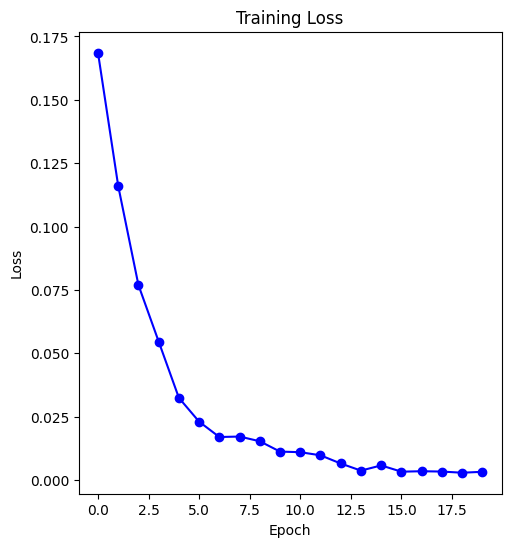

In [17]:
# Plotting training loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(loss_values, 'b-o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [18]:
# Calculate Matthews Correlation Coefficient
predictions, true_labels = [], []
for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    predictions.append(logits)
    true_labels.append(label_ids)
flat_predictions = np.argmax(np.concatenate(predictions, axis=0), axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0).flatten()
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('MCC: %.3f' % mcc)

MCC: 0.756


In [19]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.48      0.39      0.43       142
           1       0.94      0.95      0.95      1902
           2       0.89      0.89      0.89       435

    accuracy                           0.91      2479
   macro avg       0.77      0.75      0.76      2479
weighted avg       0.90      0.91      0.91      2479

